# FastAI Tabular Data Neural Network

Attempt to get fastai.tabular_learner() to solve this linear regression problem.

layers=[200,100,50] - Kaggle score is 3.25917 (terrible) and most predictions are an order of magnitude too low

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
from fastai.basic_data import DatasetType
from fastai.tabular.data import TabularDataBunch, TabularList
from fastai.tabular.transform import FillMissing, Categorify, Normalize
from fastai.tabular.learner import tabular_learner
from fastai.metrics import accuracy, r2_score, root_mean_squared_error
from fastai.data_block import FloatList
import numpy as np
import pandas as pd
import random
import pydash
import torch

# from fastai.structured import *
# np.set_printoptions(threshold=50, edgeitems=20)

In [3]:
fastai.torch_core.defaults.device = 'cpu'

In [4]:
df = pd.read_csv('data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test_df = pd.read_csv('data/test.csv').fillna(0)
test_df['SalePrice'] = 0
df.SalePrice = df.SalePrice.astype(float); # Float implies a regression problem rather than categorization 
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,0,Reg,Lvl,AllPub,...,0,0,MnPrv,0,0,6,2010,WD,Normal,0
1,1462,20,RL,81.0,14267,Pave,0,IR1,Lvl,AllPub,...,0,0,0,Gar2,12500,6,2010,WD,Normal,0
2,1463,60,RL,74.0,13830,Pave,0,IR1,Lvl,AllPub,...,0,0,MnPrv,0,0,3,2010,WD,Normal,0
3,1464,60,RL,78.0,9978,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,6,2010,WD,Normal,0
4,1465,120,RL,43.0,5005,Pave,0,IR1,HLS,AllPub,...,0,0,0,0,0,1,2010,WD,Normal,0


In [6]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
procs = [FillMissing, Categorify, Normalize]
cat_names = [
    'CentralAir',
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
    'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC',
    "MoSold",
    "LandSlope", "MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities",
    "LotConfig", "Neighborhood", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "MasVnrType", "Foundation",
    "BsmtExposure", "Heating", "Functional", "GarageFinish", "Fence", "SaleType", "SaleCondition",
    "MiscFeature", "Electrical", "GarageType", "PavedDrive",
    "Condition1", "Condition2",
    "Exterior1st", "Exterior2nd",
    "BsmtFinType1", "BsmtFinType2",
]
cont_names = [ x for x in df.columns if x not in cat_names ]

In [8]:
valid_idx  = random.sample( range(0, len(df)), len(df)//5)

In [9]:
# max_log_y = np.log( np.max(df['SalePrice'])*1.2 )
max_y   = np.max(df['SalePrice'])*1.2
y_range = torch.tensor([0, max_y])

In [10]:
data = TabularDataBunch.from_df(
    './data/', df, 
    dep_var='SalePrice', 
    valid_idx=valid_idx,
    test_df=test_df,
    procs=[FillMissing, Categorify, Normalize], 
    cat_names=cat_names,
    cont_names=cont_names,
    y_range=y_range
)
# data.add_test(TabularList.from_df(
#     test_df,
#     procs=[FillMissing, Categorify, Normalize],     
#     cat_names=cat_names,
#     cont_names=cont_names,
# ))
data

TabularDataBunch;

Train: LabelList (1168 items)
x: TabularList
CentralAir Y; ExterQual TA; ExterCond TA; BsmtQual Gd; BsmtCond TA; HeatingQC Ex; KitchenQual TA; FireplaceQu TA; GarageQual TA; GarageCond TA; PoolQC #na#; MoSold 5; LandSlope Gtl; MSSubClass 20; MSZoning RL; Street Pave; Alley #na#; LotShape Reg; LandContour Lvl; Utilities AllPub; LotConfig FR2; Neighborhood Veenker; BldgType 1Fam; HouseStyle 1Story; RoofStyle Gable; RoofMatl CompShg; MasVnrType None; Foundation CBlock; BsmtExposure Gd; Heating GasA; Functional Typ; GarageFinish RFn; Fence #na#; SaleType WD; SaleCondition Normal; MiscFeature #na#; Electrical SBrkr; GarageType Attchd; PavedDrive Y; Condition1 Feedr; Condition2 Norm; Exterior1st MetalSd; Exterior2nd MetalSd; BsmtFinType1 ALQ; BsmtFinType2 Unf; LotFrontage_na False; MasVnrArea_na False; GarageYrBlt_na False; Id -1.7101; LotFrontage 0.4883; LotArea -0.0868; OverallQual -0.0461; OverallCond 2.1525; YearBuilt 0.1865; YearRemodAdd -0.4037; MasVnrArea -0.5629; B

In [11]:
# NOTE: root_mean_squared_error throes AssertionError: Expected output and target to have the same number of elements but got 36608 and 64.
#       but only when SalesPrice is int for categorization and not float for regression
learn = tabular_learner(data=data, layers=[200,100,50], 
   metrics=[root_mean_squared_error], 
#  use_bn=False,
   y_range=y_range
)
learn

Learner(data=TabularDataBunch;

Train: LabelList (1168 items)
x: TabularList
CentralAir Y; ExterQual TA; ExterCond TA; BsmtQual Gd; BsmtCond TA; HeatingQC Ex; KitchenQual TA; FireplaceQu TA; GarageQual TA; GarageCond TA; PoolQC #na#; MoSold 5; LandSlope Gtl; MSSubClass 20; MSZoning RL; Street Pave; Alley #na#; LotShape Reg; LandContour Lvl; Utilities AllPub; LotConfig FR2; Neighborhood Veenker; BldgType 1Fam; HouseStyle 1Story; RoofStyle Gable; RoofMatl CompShg; MasVnrType None; Foundation CBlock; BsmtExposure Gd; Heating GasA; Functional Typ; GarageFinish RFn; Fence #na#; SaleType WD; SaleCondition Normal; MiscFeature #na#; Electrical SBrkr; GarageType Attchd; PavedDrive Y; Condition1 Feedr; Condition2 Norm; Exterior1st MetalSd; Exterior2nd MetalSd; BsmtFinType1 ALQ; BsmtFinType2 Unf; LotFrontage_na False; MasVnrArea_na False; GarageYrBlt_na False; Id -1.7101; LotFrontage 0.4883; LotArea -0.0868; OverallQual -0.0461; OverallCond 2.1525; YearBuilt 0.1865; YearRemodAdd -0.4037; MasVnrAr

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


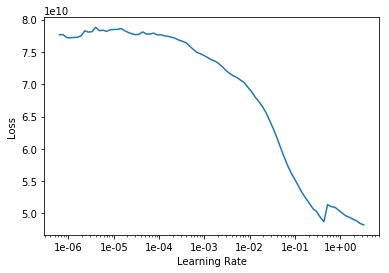

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(100, 5e-02)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,59671474176.000000,37453881344.000000,193486.484375,00:01
1,49500606464.000000,30476283904.000000,174532.781250,00:01
2,37266092032.000000,12128918528.000000,109951.000000,00:01
3,24375922688.000000,1724071680.000000,40698.683594,00:01
4,16418547712.000000,5880842240.000000,75616.273438,00:01
5,11571193856.000000,2118359424.000000,45663.261719,00:01
6,8330380288.000000,680629632.000000,25919.421875,00:01
7,5892263424.000000,614187328.000000,24510.591797,00:01
8,4245089792.000000,1200181376.000000,34163.332031,00:01
9,3135105280.000000,1038031680.000000,31194.451172,00:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


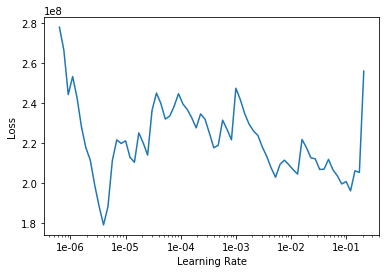

In [14]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(50, 2e-06)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,113446152.000000,15897938.000000,3745.112549,00:02
1,129884336.000000,28211240.000000,5113.456543,00:02
2,234594240.000000,30131944.000000,5287.564941,00:02
3,203283968.000000,29638194.000000,5235.994629,00:02
4,182774608.000000,43892424.000000,6418.686035,00:02
5,168196944.000000,23538564.000000,4636.299805,00:02
6,150719616.000000,32632454.000000,5499.531738,00:02
7,163675552.000000,36303688.000000,5831.625977,00:02
8,143060560.000000,34146340.000000,5640.207520,00:02
9,174387344.000000,67331656.000000,8027.154297,00:02


In [78]:
preds = learn.get_preds(ds_type=DatasetType.Test)[0].numpy().flatten(); preds
submission_df = pd.DataFrame({
    'Id':        test_df['Id'], 
    'SalePrice': preds
})
submission_df.to_csv('data/submissions/fastai.csv', header=True, index=False)
submission_df.head()

,Id,SalePrice
0,1461,22509.003906
1,1462,27194.025391
2,1463,37128.050781
3,1464,37212.187500
4,1465,26778.488281


# Submit to Kaggle

```
kaggle competitions submit -c house-prices-advanced-regression-techniques -f data/submissions/fastai.csv -m "Fastai tabular_learner"
```